https://data.mendeley.com/datasets/jxpfjc64kr/1

This is a SDN specific data set generated by using mininet emulator and used for traffic classification by machine learning and deep learning algorithms.
The project start by creating ten topologies in mininet in which switches are connected to single Ryu controller.  Network simulation runs for benign TCP, UDP and ICMP traffic and malicious traffic which is the collection of TCP Syn attack, UDP Flood attack, ICMP attack.
Total 23 features are available in the data set in which some are extracted from the switches  and others are calculated.
#### Features
Extracted features include Switch-id,
- Packet_count,
- byte_count,
- duration_sec,
- duration_nsec which is duration in nano-seconds,
- total duration is sum of duration_sec and durstaion_nsec,
- Source IP, Destination IP, Port number,
- tx_bytes is the number of bytes transferred from the switch port,
- rx_bytes is the number of bytes received on  the switch port. 
- dt field show the date and time which has been converted into number and a flow is monitored at a monitoring -interval of 30 second.
- Calculated features include Packet per flow which is packet count during a single flow,
- Byte per flow is byte count during a single flow,
- Packet Rate is number of packets send per second and calculated by dividing the packet per flow by monitoring interval, number of Packet_ins messages, total flow entries in the switch,
- tx_kbps,rx_kbps are data transfer and receiving rate and Port Bandwidth is the sum of tx_kbps and rx_kbps.
#### Target
Last column indicates the class label which indicates whether the traffic type is benign or malicious. Benign traffic has label 0 and malicious traffic has label 1.  Network simulation is run for 250 minutes and 1,04,345 rows of data is collected. The simulation is run for defined interval again and more data can be collected.

In [645]:
#pip install seaborn

In [646]:
pip install pydot

Note: you may need to restart the kernel to use updated packages.


#### Importado a biblioteca e o dataset

In [647]:
import pandas as pd
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.set_option('display.max_columns', None)

#### Bibliotecas de deep learning

In [648]:
import tensorflow as tf
from tensorflow import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

In [649]:
df = pd.read_csv('dataset_sdn.csv')

#### Verificando valores NaN

In [650]:
df.isna().any()

dt             False
switch         False
src            False
dst            False
pktcount       False
bytecount      False
dur            False
dur_nsec       False
tot_dur        False
flows          False
packetins      False
pktperflow     False
byteperflow    False
pktrate        False
Pairflow       False
Protocol       False
port_no        False
tx_bytes       False
rx_bytes       False
tx_kbps        False
rx_kbps         True
tot_kbps        True
label          False
dtype: bool

In [651]:
df['rx_kbps'].sample(5)

100778    1.0
14727     0.0
82355     0.0
16224     0.0
68245     0.0
Name: rx_kbps, dtype: float64

In [652]:
df['tot_kbps'].sample(5)

37917        0.0
89356     4669.0
55791        2.0
63512        0.0
103034       2.0
Name: tot_kbps, dtype: float64

#### Inserindo média dos valores da coluna onde os valores são NaN

In [653]:
df['rx_kbps'].fillna((df['rx_kbps'].mean()), inplace=True)

In [654]:
df['tot_kbps'].fillna((df['tot_kbps'].mean()), inplace=True)

In [655]:
df['rx_kbps'].isna().any()

False

In [656]:
df['tot_kbps'].isna().any()

False

#### Verificando valores Nulos

In [657]:
df.isnull().any()

dt             False
switch         False
src            False
dst            False
pktcount       False
bytecount      False
dur            False
dur_nsec       False
tot_dur        False
flows          False
packetins      False
pktperflow     False
byteperflow    False
pktrate        False
Pairflow       False
Protocol       False
port_no        False
tx_bytes       False
rx_bytes       False
tx_kbps        False
rx_kbps        False
tot_kbps       False
label          False
dtype: bool

In [658]:
df.sample(5)

,dt,switch,src,dst,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,Protocol,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label
38320,24791,5,10.0.0.14,10.0.0.4,83970,4534380,296,146000000,2.960000e+11,5,10817,7940,428760,264,1,TCP,2,5329,1242,0,0.0,0.0,1
90637,25170,5,10.0.0.10,10.0.0.3,12,1176,12,964000000,1.296400e+10,11,3021,0,0,0,1,ICMP,1,271157416,269079816,2,2.0,4.0,0
29365,4059,5,10.0.0.8,10.0.0.5,106698,113740068,237,281000000,2.370000e+11,2,8803,13375,14257750,445,0,UDP,3,566379701,6035,0,0.0,0.0,0
53942,32523,2,10.0.0.10,10.0.0.3,5612,5847704,15,786000000,1.578600e+10,9,2332,0,0,0,1,ICMP,1,6266226,5448530,1662,1445.0,3107.0,1
101027,6762,5,10.0.0.9,10.0.0.2,792,77616,811,599000000,8.120000e+11,11,3443,29,2842,0,0,ICMP,4,135532771,406641779,1,1.0,2.0,0


#### Análise das colunas:
- dt: não especificado na documentação
- switch: identificação do switch openflow
- src e dst: origem e destino dos pacotes, muitos ips para categorizar, melhor solução seria isolar por enquanto
- pktcount: contagem de pacotes
- bytecount: contagem de bytes
- dur: duração em segundos
- dur_nsec: duração em nanosegundos
- tot_dur: duração total
- flows: quantidades de fluxos

#### Gerando dummy variables para as colunas categoricas

In [659]:
df = pd.get_dummies(df, columns=['src','dst','Protocol'])

In [660]:
df.sample(5)

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,label,src_10.0.0.1,src_10.0.0.10,src_10.0.0.11,src_10.0.0.12,src_10.0.0.13,src_10.0.0.14,src_10.0.0.15,src_10.0.0.16,src_10.0.0.17,src_10.0.0.18,src_10.0.0.2,src_10.0.0.20,src_10.0.0.3,src_10.0.0.4,src_10.0.0.5,src_10.0.0.6,src_10.0.0.7,src_10.0.0.8,src_10.0.0.9,dst_10.0.0.1,dst_10.0.0.10,dst_10.0.0.11,dst_10.0.0.12,dst_10.0.0.13,dst_10.0.0.14,dst_10.0.0.15,dst_10.0.0.16,dst_10.0.0.17,dst_10.0.0.18,dst_10.0.0.2,dst_10.0.0.3,dst_10.0.0.4,dst_10.0.0.5,dst_10.0.0.6,dst_10.0.0.7,dst_10.0.0.8,dst_10.0.0.9,Protocol_ICMP,Protocol_TCP,Protocol_UDP
70142,7057,4,125002,141366140,294,327000000,2.940000e+11,11,11888,12044,13394200,401,1,3,9537645,238868138,292,7259.0,7551.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
8534,10056,3,134820,143718120,322,102000000,3.220000e+11,4,1931,2900,3091400,96,0,1,3669,1402,0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1
539,11395,1,31769,33865754,70,715000000,7.071500e+10,3,1943,13463,14351558,448,0,3,3413,3665,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1
50927,27918,3,391,38318,401,85000000,4.010000e+11,8,2790,29,2842,0,1,3,271193415,135734995,1,1.0,2.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
62593,29322,6,458,44884,470,169000000,4.700000e+11,4,1057,29,2842,0,1,2,109775385,50827,2512,0.0,2512.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [661]:
df.shape

(104345, 60)

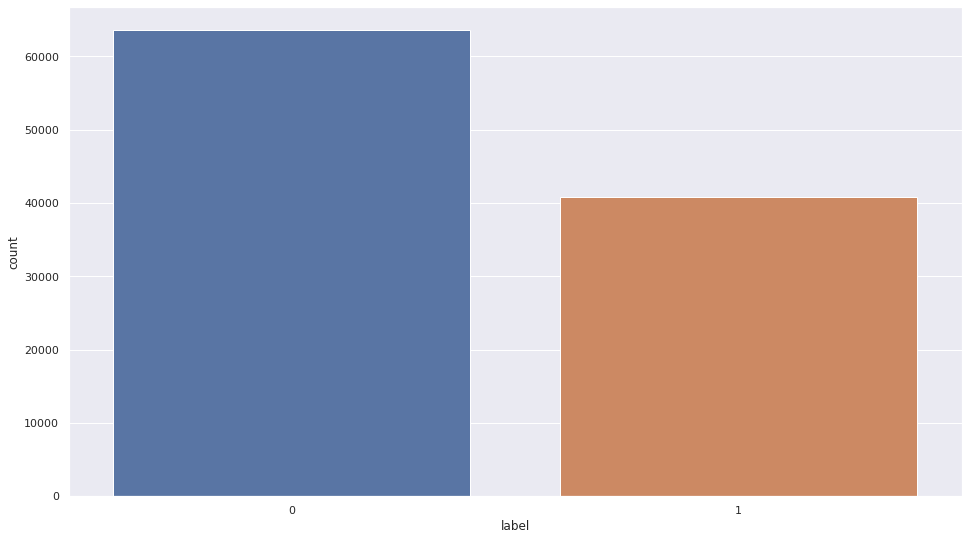

In [662]:
ax = sns.countplot(x="label", data=df)

In [663]:
df.shape

(104345, 60)

#### Separando features e target

##### Coletando as features. Todas as colunas menos a coluna label que será target

In [664]:
features = df.drop(['label'],axis=1)

In [665]:
features.sample(5)

,dt,switch,pktcount,bytecount,dur,dur_nsec,tot_dur,flows,packetins,pktperflow,byteperflow,pktrate,Pairflow,port_no,tx_bytes,rx_bytes,tx_kbps,rx_kbps,tot_kbps,src_10.0.0.1,src_10.0.0.10,src_10.0.0.11,src_10.0.0.12,src_10.0.0.13,src_10.0.0.14,src_10.0.0.15,src_10.0.0.16,src_10.0.0.17,src_10.0.0.18,src_10.0.0.2,src_10.0.0.20,src_10.0.0.3,src_10.0.0.4,src_10.0.0.5,src_10.0.0.6,src_10.0.0.7,src_10.0.0.8,src_10.0.0.9,dst_10.0.0.1,dst_10.0.0.10,dst_10.0.0.11,dst_10.0.0.12,dst_10.0.0.13,dst_10.0.0.14,dst_10.0.0.15,dst_10.0.0.16,dst_10.0.0.17,dst_10.0.0.18,dst_10.0.0.2,dst_10.0.0.3,dst_10.0.0.4,dst_10.0.0.5,dst_10.0.0.6,dst_10.0.0.7,dst_10.0.0.8,dst_10.0.0.9,Protocol_ICMP,Protocol_TCP,Protocol_UDP
91056,31311,5,383,37534,392,837000000,3.930000e+11,5,4942,29,2842,0,1,1,271228025,269150054,0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
28881,3249,5,88504,94345264,193,347000000,1.930000e+11,4,7894,13531,14424046,451,0,3,4304,110593902,0,6476.0,6476.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
65685,30072,1,131234,135580932,1070,133000000,1.070000e+12,5,2053,30,2940,1,1,2,135486107,35696,0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
55562,32943,3,525,51450,538,497000000,5.380000e+11,3,2364,29,2842,0,1,3,135518338,134703620,0,0.0,0.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
43117,31453,2,10754,580716,16,882000000,1.688200e+10,9,10692,0,0,0,1,2,183373858,154118294,11607,607.0,12214.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [666]:
features.shape

(104345, 59)

In [667]:
features.dtypes

dt                 int64
switch             int64
pktcount           int64
bytecount          int64
dur                int64
dur_nsec           int64
tot_dur          float64
flows              int64
packetins          int64
pktperflow         int64
byteperflow        int64
pktrate            int64
Pairflow           int64
port_no            int64
tx_bytes           int64
rx_bytes           int64
tx_kbps            int64
rx_kbps          float64
tot_kbps         float64
src_10.0.0.1       uint8
src_10.0.0.10      uint8
src_10.0.0.11      uint8
src_10.0.0.12      uint8
src_10.0.0.13      uint8
src_10.0.0.14      uint8
src_10.0.0.15      uint8
src_10.0.0.16      uint8
src_10.0.0.17      uint8
src_10.0.0.18      uint8
src_10.0.0.2       uint8
src_10.0.0.20      uint8
src_10.0.0.3       uint8
src_10.0.0.4       uint8
src_10.0.0.5       uint8
src_10.0.0.6       uint8
src_10.0.0.7       uint8
src_10.0.0.8       uint8
src_10.0.0.9       uint8
dst_10.0.0.1       uint8
dst_10.0.0.10      uint8


In [668]:
features = features.astype({
    'dt': float,
    'switch': float,
    'pktcount': float,
    'bytecount':float,
    'dur': float,
    'dur_nsec': float,
    'flows': float,
    'packetins': float,
    'pktperflow': float,
    'byteperflow': float,
    'pktrate': float,
    'Pairflow': float,
    'port_no': float,
    'tx_bytes': float,
    'rx_bytes': float,
    'tx_kbps': float,
    
})

In [669]:
features.dtypes

dt               float64
switch           float64
pktcount         float64
bytecount        float64
dur              float64
dur_nsec         float64
tot_dur          float64
flows            float64
packetins        float64
pktperflow       float64
byteperflow      float64
pktrate          float64
Pairflow         float64
port_no          float64
tx_bytes         float64
rx_bytes         float64
tx_kbps          float64
rx_kbps          float64
tot_kbps         float64
src_10.0.0.1       uint8
src_10.0.0.10      uint8
src_10.0.0.11      uint8
src_10.0.0.12      uint8
src_10.0.0.13      uint8
src_10.0.0.14      uint8
src_10.0.0.15      uint8
src_10.0.0.16      uint8
src_10.0.0.17      uint8
src_10.0.0.18      uint8
src_10.0.0.2       uint8
src_10.0.0.20      uint8
src_10.0.0.3       uint8
src_10.0.0.4       uint8
src_10.0.0.5       uint8
src_10.0.0.6       uint8
src_10.0.0.7       uint8
src_10.0.0.8       uint8
src_10.0.0.9       uint8
dst_10.0.0.1       uint8
dst_10.0.0.10      uint8


In [670]:
features = np.asarray(features).astype(np.float32)

##### Definingo target como sendo a coluna label

In [671]:
target = to_categorical(df['label'])

In [672]:
target

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [673]:
target.dtype

dtype('float32')

In [674]:
target.shape

(104345, 2)

#### Modelo com uma camada

In [675]:
model = Sequential()
model.add(Dense(50, activation='relu',input_shape=(59,))) 
model.add(Dense(2, activation='sigmoid'))

#### Variando o modelo

In [676]:
model = Sequential()
model.add(Dense(50, activation='relu',input_shape=(59,)))
model.add(Dense(50, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [677]:
model = Sequential()
model.add(Dense(30, activation='relu',input_shape=(59,)))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [678]:
model = Sequential()
model.add(Dense(30, activation='relu',input_shape=(59,)))
model.add(Dense(30, activation='relu'))
model.add(Dense(30, activation='relu'))
model.add(Dense(2, activation='softmax'))

### Comparando otimizadores

#### Otimizador SGD

In [679]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.SGD(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    model.fit(features, target)

Learning Rate: 1e-06
3261/3261 [==============================] - 38s 11ms/step - loss: nan - accuracy: 0.6090
Learning Rate: 0.01
3261/3261 [==============================] - 55s 16ms/step - loss: nan - accuracy: 0.6091
Learning Rate: 1.1
3261/3261 [==============================] - 32s 9ms/step - loss: nan - accuracy: 0.6091


#### Otimizador RMSprop

In [680]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.RMSprop(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    model.fit(features, target)

Learning Rate: 1e-06
3261/3261 [==============================] - 8s 2ms/step - loss: nan - accuracy: 0.6091
Learning Rate: 0.01
3261/3261 [==============================] - 12s 3ms/step - loss: nan - accuracy: 0.6091
Learning Rate: 1.1
3261/3261 [==============================] - 14s 4ms/step - loss: nan - accuracy: 0.6091


#### Otimizador Adam

In [681]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.Adam(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    model.fit(features, target)

Learning Rate: 1e-06
3261/3261 [==============================] - 14s 4ms/step - loss: nan - accuracy: 0.6091
Learning Rate: 0.01
3261/3261 [==============================] - 14s 4ms/step - loss: nan - accuracy: 0.6091
Learning Rate: 1.1
3261/3261 [==============================] - 14s 4ms/step - loss: nan - accuracy: 0.6091


#### Otimizador Adadelta

In [ ]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.Adadelta(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    model.fit(features, target)

Learning Rate: 1e-06
3261/3261 [==============================] - 13s 4ms/step - loss: nan - accuracy: 0.6091
Learning Rate: 0.01
3261/3261 [==============================] - 13s 4ms/step - loss: nan - accuracy: 0.6091
Learning Rate: 1.1
 116/3261 [>.............................] - ETA: 11s - loss: nan - accuracy: 0.6161

#### Otimizador Adagrad

In [ ]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.Adagrad(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    model.fit(features, target)

#### Otimizador Adamax

In [ ]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.Adamax(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    model.fit(features, target)

#### Otimizador Nadam

In [ ]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.Nadam(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    model.fit(features, target)

#### Otimizador Ftrl

In [ ]:
lr_to_test = [.000001, 0.01, 1.1]

#opt = ['SGD','RMSprop','Adam','Adadelta','Adagrad','Adamax','Nadam','Ftrl']

# loop over learning rates
for lra in lr_to_test:
    opt = keras.optimizers.Ftrl(learning_rate=lra)
    print('Learning Rate:', lra)
    model.compile(optimizer=opt,loss='categorical_crossentropy',metrics='accuracy') 
    history = model.fit(features, target)
history

In [ ]:
sns.set(rc = {'figure.figsize':(16,9)})
mask = np.triu(df.corr())
corrMatrix = df.corr()
sns.heatmap(corrMatrix, annot=False,vmin=-1,vmax=1,cmap='coolwarm',mask=mask,linewidths=1.0)
plt.show()

In [ ]:
corrMatrix.columns

In [ ]:
pos = corrMatrix[corrMatrix.label > 0.2]

In [ ]:
neg = corrMatrix[corrMatrix.label < -0.2]

In [ ]:
sns.heatmap(pos, annot=False,vmin=-1,vmax=1,cmap='coolwarm',linewidths=1.0)

In [ ]:
sns.heatmap(neg, annot=False,vmin=-1,vmax=1,cmap='coolwarm',linewidths=1.0)